## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Намит Максим Михайлович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

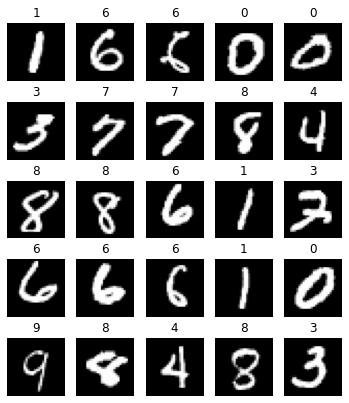

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9878784418106079
forward 0.8150575757026672
forward 0.7072015404701233
forward 0.5819935202598572
forward 0.5104367136955261
forward 0.39847177267074585
forward 0.3645019829273224
forward 0.2877841293811798
forward 0.2606700658798218
forward 0.19102759659290314
forward 0.0764438733458519
forward 0.053458575159311295
forward 0.04965382441878319
forward 0.02351730316877365
forward 0.01899709925055504
forward 0.014358509331941605
forward 0.01326469425112009
forward 0.008331251330673695
forward 0.004231210798025131
forward 0.0028025275096297264
forward 0.0016178097575902939
forward 0.0013766296906396747
forward 0.00136239780113101
forward 0.000766001467127353
forward 0.0005812987219542265
forward 0.0005493697826750576
forward 0.0003964213246945292
forward 0.000314414530294016
forward 0.00023882459208834916
forward 0.00016748264897614717
forward 9.345776925329119e-05
forward 7.700067362748086e-05
forward 4.0871029341360554e-05
backward 0.03299831598997116
backward 0.10887507349252

/home/namitmax/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def he(size_input, size_output):
    d = 2 / (size_input)
    return np.sqrt(d)

init_func = he
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


In [10]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9878784418106079
forward 0.7803810238838196
forward 0.7730829119682312
forward 0.701545238494873
forward 0.47059598565101624
forward 0.30634674429893494
forward 0.2838428318500519
forward 0.20055602490901947
forward 0.1358991414308548
forward 0.07953011244535446
forward 0.07522232830524445
forward 0.07322071492671967
forward 0.046652134507894516
forward 0.04395512491464615
forward 0.03410723805427551
forward 0.026627689599990845
forward 0.01898343116044998
forward 0.03128371015191078
forward 0.026593387126922607
forward 0.022813960909843445
forward 0.03362467885017395
forward 0.03903709724545479
forward 0.040951333940029144
forward 0.04380597919225693
forward 0.05805550143122673
forward 0.05098578333854675
forward 0.053517743945121765
forward 0.0594424270093441
forward 0.06805787235498428
forward 0.06518411636352539
forward 0.08193337172269821
forward 0.07398874312639236
forward 0.11112108826637268
backward 0.03299831598997116
backward 0.08354832977056503
backward 0.036595661

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [22]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [23]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [24]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.026/0.064	Accuracy: 0.991/0.981


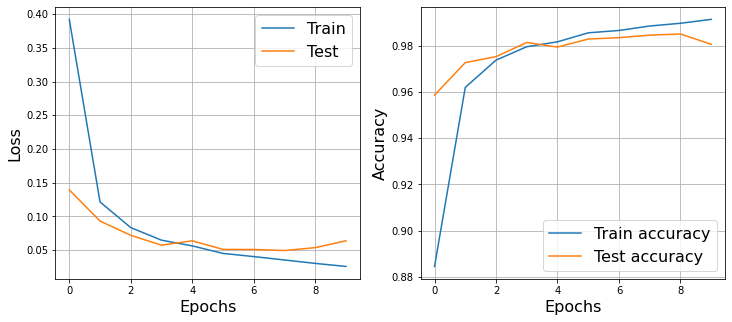

CPU times: user 1min 54s, sys: 1.79 s, total: 1min 55s
Wall time: 1min 56s


In [13]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.438/0.061	Accuracy: 0.783/0.982


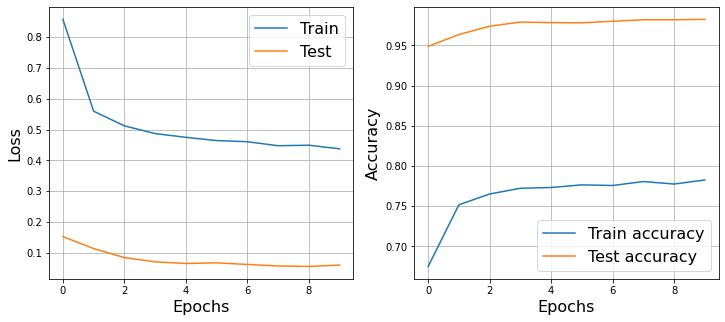

CPU times: user 1min 51s, sys: 439 ms, total: 1min 51s
Wall time: 1min 51s


In [15]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.154/0.332	Accuracy: 0.952/0.969


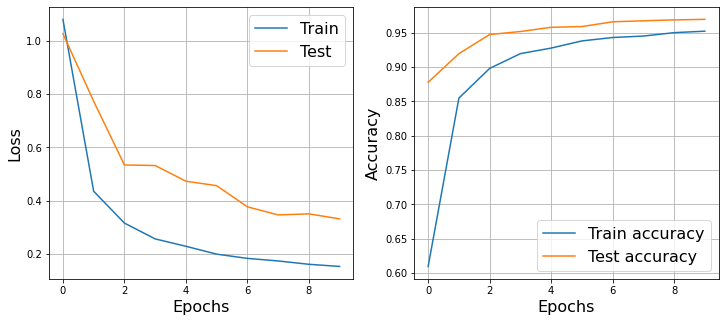

CPU times: user 1min 54s, sys: 413 ms, total: 1min 54s
Wall time: 1min 54s


In [17]:
%%time

#dropconnect
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [6]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(size).fill_(1.))
        self.betta = nn.Parameter(torch.FloatTensor(size).fill_(0.)) 
    
    def forward(self, x):
        return (x - x.mean(1, keepdim = True)) / (x.std(1, keepdim = True) + 1e-6) * self.gamma + self.betta

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [7]:
train_loader.batch_size

128

In [8]:
from train_utils import train


Epoch 9... (Train/Test) NLL: -20.307/-21.247	Accuracy: 0.992/0.982


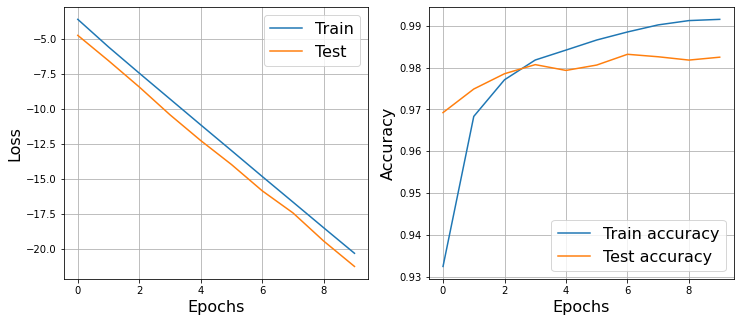

([-3.589981212544797,
  -5.5623695692782205,
  -7.43522406539429,
  -9.28387434091141,
  -11.132646576936311,
  -12.969850072474367,
  -14.819264096746059,
  -16.64935205943549,
  -18.48646640574246,
  -20.307292612885107],
 [-4.733376708211778,
  -6.544767023641852,
  -8.423155844966068,
  -10.411789290512665,
  -12.253350632100165,
  -13.965969073621533,
  -15.843820004523556,
  -17.42237723628177,
  -19.43494690520854,
  -21.247306389144704],
 [0.9324527,
  0.96833354,
  0.97709554,
  0.9818208,
  0.9841973,
  0.98660713,
  0.9885283,
  0.99022186,
  0.99124914,
  0.99154335],
 [0.9692445,
  0.97488135,
  0.97854036,
  0.980716,
  0.9793315,
  0.9806171,
  0.9831883,
  0.9825949,
  0.9818038,
  0.982496])

In [9]:
network = nn.Sequential(nn.Flatten(), 
                        nn.Linear(784, 128), nn.BatchNorm1d(128), nn.ReLU(),
                        nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
                        nn.Linear(128,10), nn.BatchNorm1d(10), nn.ReLU())

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: -19.428/-20.081	Accuracy: 0.988/0.973


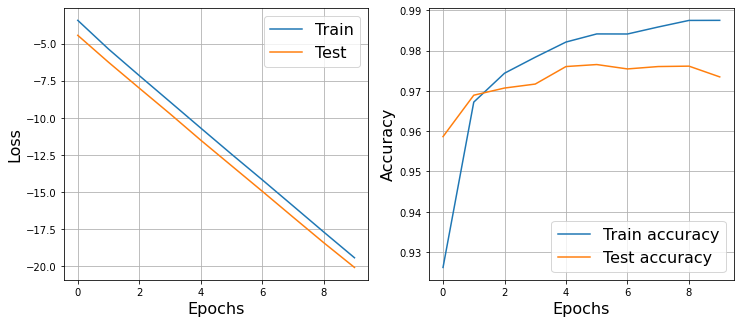

([-3.4312987328846574,
  -5.365639044023526,
  -7.154181633930979,
  -8.919106110326771,
  -10.688850392664929,
  -12.44616412709771,
  -14.175356720556328,
  -15.931338588820337,
  -17.692546401196704,
  -19.428035923158692],
 [-4.440362676789489,
  -6.25477307959448,
  -7.9985332730450205,
  -9.729001769536659,
  -11.505250194404699,
  -13.226688457440726,
  -14.946109964877744,
  -16.68685968616341,
  -18.413564343995684,
  -20.081033779096],
 [0.9261672,
  0.96723413,
  0.9744081,
  0.9783837,
  0.982154,
  0.9841696,
  0.9841529,
  0.98589087,
  0.9875233,
  0.98754],
 [0.958663,
  0.96894777,
  0.97072786,
  0.97171676,
  0.976068,
  0.9765625,
  0.97547466,
  0.976068,
  0.9761669,
  0.97349685])

In [11]:
network = nn.Sequential(nn.Flatten(), 
                        nn.Linear(784, 128), LayerNormalization(128), nn.ReLU(),
                        nn.Linear(128, 128), LayerNormalization(128), nn.ReLU(),
                        nn.Linear(128, 10), LayerNormalization(10), nn.ReLU())

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Batch Normalization показал несколько лучший результат по сравнению с Layer Normalization, также сложилось впечатление что  Batch Normalization работает несколько стабильнее, с каждой итерацией loss уменьшался в отличие от Layer Normalization.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара: